In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ims_path = "/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/"

In [3]:
files = []
for filename in os.listdir(ims_path):
    if filename.endswith(".npz"):
        im_file = os.path.join(ims_path, filename)
        files.append(im_file)

In [4]:
def extract_num_from_npy_string(string):
    numbers = re.findall("[0-9]+", string[-9:])
    numbers = int(numbers[0])
    return numbers

In [5]:
fnames = sorted(files, key=extract_num_from_npy_string)

In [6]:
fnames

['/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im0.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im1.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im2.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im3.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im4.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im5.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im6.npz',
 '/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/processed_ims/extracted_data/im7.npz',
 '/Users

In [7]:
# fnames = [
#     "im01",
#     "im02",
#     "im03",
#     "im04",
#     "im05",
#     "im06",
#     "im07",
#     "im08",
#     "im09",
#     "im10",
#     "im11",
#     "im12",
#     "im13",
# ]
# fnames = ["bi26_g54e/extracted_data/" + s + ".npz" for s in fnames]


# format is cropped image, interpolated line, interpolation points, curvature, and crop points!
cropped_images = []
interpolated_lines = []
interpolation_points = []
curvatures = []
# crop_points = []

# populate the arrays
for f in fnames:
    arr = np.load(f)
    cropped_images.append(arr["arr_0"])
    interpolated_lines.append(arr["arr_1"])
    interpolation_points.append(arr["arr_2"])
    curvatures.append(arr["arr_3"])
    # crop_points.append(arr["arr_4"])

## First create the tuples

In [8]:
n_ims = len(interpolation_points)
frms_list = []
for i in range(n_ims):
    frmi = list(zip(interpolation_points[i], curvatures[i]))
    frms_list.append(frmi)

In [9]:
def deal_with_zero_dup(tup_list: list, arr_idx: int, n_ims: int) -> list:
    """
    Drop the tuples which duplicate zero starting elements

    Just gets rid of duplicates in the list and makes interpolation easier.
    In general this is a dirty method but it's better than nothing.
    """
    zero_start_list = [i for i in tup_list if i[0] == 0.0]
    tup_list = tup_list[n_ims:]  # ignore the first n_ims things
    tup = zero_start_list[arr_idx]
    tup_list.insert(0, tup)
    return tup_list

## Now I need to go through and append the curvatures that are not the same

In [10]:
zeros_list = np.zeros(100)
padded_frames = []
for i in range(n_ims):
    frmi = frms_list[i]
    idxs = list(np.linspace(0, n_ims - 1, n_ims, dtype=int))
    idxs.remove(i)
    for idx in idxs:
        zipped = list(zip(interpolation_points[idx], zeros_list))
        frmi.extend(zipped)
    frmi.sort(key=lambda el: el[0])
    frmi = deal_with_zero_dup(frmi, i, n_ims)
    padded_frames.append(frmi)

In [11]:
ext_curvatures = []
for lst in padded_frames:
    ext_curve = [tup[1] for tup in lst]
    ext_curvatures.append(ext_curve)

In [12]:
curve_mat = np.vstack(ext_curvatures)

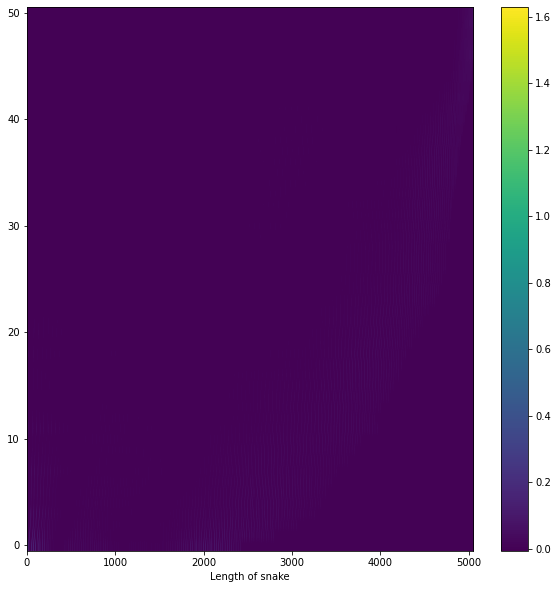

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(curve_mat[::], aspect="auto", origin="lower")
plt.colorbar()
plt.xlabel("Length of snake")
# plt.show()
plt.savefig("time_kymograph.png")

## Now I need to figure out some kind of interpolation scheme to get rid of the stripes where I don't really want them

### sample code for one frame

In [ ]:
frm1 = list(zip(interpolation_points[0], curvatures[0]))
for i in range(1, 13):
    zipped = list(zip(interpolation_points[i], zeros_list))
    frm1.extend(zipped)

In [ ]:
frm1.sort(key=lambda el: el[0])

In [ ]:
frm1 = deal_with_zero_dup(frm1)

In [ ]:
frm1_ext_curve = [tup[1] for tup in frm1]